# Regression for catboost Marine data with accessory physical parameters

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

import pandas as pd
import seaborn as sns
import ipywidgets
from sklearn import decomposition, metrics
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix
from catboost import CatBoostClassifier, Pool, cv, CatBoostRegressor
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoost
from sklearn import preprocessing
from catboost.utils import eval_metric
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import pickle
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap

### Read in the dataset and drop empty columns or rows

In [2]:
def read_in_data_filter_integer_labels(grouped = 0,
                        csv = "/global/cfs/cdirs/kbase/KE-Catboost/HK/mode_0/copy_number_abundance.csv"):
    df = pd.read_csv(csv)
    df = df.drop('Unnamed: 0', axis=1)
    df = df.fillna(0)

    grouped_df = df.groupby('biome').filter(lambda x : len(x) > grouped)
    grouped_df = grouped_df.reset_index(drop=True)
    print(grouped_df['biome'].nunique())

    
    # drop constant columns
    print(grouped_df.shape)
    # record columns to delete
    counts = grouped_df.nunique()
    to_del = [i for i,v in enumerate(counts) if v == 1]
    print('constant columns: ',to_del)
    # drop useless columns
    grouped_df.drop(grouped_df.columns[[to_del]],axis = 1, inplace=True)
    print(grouped_df.shape)
    
    le = preprocessing.LabelEncoder()
    le.fit(grouped_df.biome)
    #list(le.classes_)
    le.transform(grouped_df.biome)
    
    return grouped_df, le

In [74]:
# Plotting functions are from from ziming github
# https://github.com/Yzm1234/KE/blob/master/lib/ plot and data_prepare

def dataset_split(df, train=0.7, val=0.2, test=0.1, random_state=42):
    df_train, df_rest = train_test_split(df, train_size=train, random_state=random_state)
    val_test_ratio = val/(val+test)
    df_val, df_test = train_test_split(df_rest, train_size=val_test_ratio, random_state=random_state)
    return df_train, df_val, df_test
def split_the_data_set(X_, y_, random_state=42):
    X_['biome'] = y_
    ### split dataset
    df_train, df_val, df_test = dataset_split(X_, random_state=random_state)
    
    y_ = X_['biome']
    X_ = X_.drop('biome', axis=1)
    ### Prep Catboost pool
    X_train = df_train.drop('biome', axis=1)
    y_train = df_train['biome']
    X_train_pool = Pool(data=X_train, label=y_train,)

    X_val = df_val.drop('biome', axis=1)
    y_val = df_val['biome']
    X_val_pool = Pool(data=X_val,label=y_val)

    X_test = df_test.drop('biome', axis=1)
    y_test = df_test['biome']
    
    return X_train, y_train, X_train_pool, X_val, y_val, X_val_pool, X_test, y_test 
def fit_data(leng):
    model.fit(X_train_pool, eval_set=X_val_pool, plot=True,snapshot_file='missing',
         # early_stopping_rounds=15
        )
    print("Test data score: "+str(model.score(X_test, y_test)))
    print("Validate data score: "+str(model.score(X_val, y_val)))
    print("Train data score: "+str(model.score(X_train, y_train)))

## read in the dataset and merge with IMG accessory dataset

In [4]:
# read in the dataset
g, le = read_in_data_filter_integer_labels(grouped=0) 

78
(16223, 14992)
constant columns:  []


Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(16223, 14992)


# Nitrogen 

In [58]:
h = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")
h['GOLD Analysis Project ID'] = h.GOLD
h = h.fillna(0)

# adjust code below depending on physical parameter currently testing (N2, T, etc)
#h = h[h.biome_specific.str.contains("Environmental")]
h = h[h.biome_specific=="Environmental:Aquatic:Marine"]
h = h[h.N2 != 0]
h = h[['GOLD Analysis Project ID', 'N2']]
g_copy = h.merge(g, on='GOLD Analysis Project ID', how='left')
g_copy = g_copy[g_copy['112326.0']>-100]

In [ ]:
y_ = g_copy.N2
X_ = g_copy.drop(['biome','GOLD Analysis Project ID', 'N2'], axis=1)
print('length: ',len(X_))

#Best Params :  {'l2_leaf_reg': 1, 'iterations': 5000, 'learning_rate': 0.01, 'bootstrap_type': 'Bernoulli'}

model = CatBoostRegressor(learning_rate=0.01, bootstrap_type = 'Bernoulli', 
                          depth = 8, l2_leaf_reg=1,
                          iterations=5000,
                           verbose = 1000,random_seed=42,
                          loss_function='RMSE',task_type="GPU",)

X_train, y_train, X_train_pool, X_val, y_val, X_val_pool, X_test, y_test = split_the_data_set(X_, y_, random_state=42)
fit_data(leng=2000)

In [ ]:
model = CatBoostRegressor(learning_rate=0.001, bootstrap_type = 'Bayesian', 
                          depth = 8, l2_leaf_reg=10,
                          iterations=10000,
                           verbose = 500,random_seed=42,
                          loss_function='RMSE',
                          task_type="GPU",)

# Oxygen

In [76]:
h = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")
h['GOLD Analysis Project ID'] = h.GOLD
h = h.fillna(0)
#h = h[h.biome_specific.str.contains("Environmental")]
h = h[h.biome_specific=="Environmental:Aquatic:Marine"]

h = h[h.O2 != 0]
h = h[['GOLD Analysis Project ID', 'O2']]
g_copy = h.merge(g, on='GOLD Analysis Project ID', how='left')
g_copy = g_copy[g_copy['112326.0']>-100]

y_ = g_copy.O2
X_ = g_copy.drop(['biome','GOLD Analysis Project ID', 'O2'], axis=1)
print('length: ',len(X_))

#Best Params :  {'l2_leaf_reg': 1, 'iterations': 5000, 'learning_rate': 0.01, 'bootstrap_type': 'Bernoulli'}

model = CatBoostRegressor(learning_rate=0.01, bootstrap_type = 'Bernoulli', 
                          depth = 8, l2_leaf_reg=1,
                          iterations=5000,
                           verbose = 1000,random_seed=42,
                          loss_function='RMSE',task_type="GPU",)

X_train, y_train, X_train_pool, X_val, y_val, X_val_pool, X_test, y_test = split_the_data_set(X_, y_, random_state=42)
fit_data(leng=2000)

length:  246


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 79.7711388	test: 74.4887849	best: 74.4887849 (0)	total: 9.79ms	remaining: 49s
1000:	learn: 14.9525966	test: 39.1489136	best: 39.1489136 (1000)	total: 7.45s	remaining: 29.8s
2000:	learn: 10.8914552	test: 38.4169878	best: 38.4165998 (1999)	total: 14.8s	remaining: 22.3s
3000:	learn: 9.2686354	test: 38.1072726	best: 38.1072307 (2999)	total: 22.3s	remaining: 14.8s
4000:	learn: 8.4416451	test: 38.0696319	best: 38.0519457 (3578)	total: 29.6s	remaining: 7.4s
4999:	learn: 7.9020263	test: 38.0766924	best: 38.0519457 (3578)	total: 37s	remaining: 0us
bestTest = 38.05194573
bestIteration = 3578
Shrink model to first 3579 iterations.
Test data score: 0.6598819177902624
Validate data score: 0.7396596237037638
Train data score: 0.988236617668527


# Temperature 

In [109]:
h = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")
h['GOLD Analysis Project ID'] = h.GOLD
h = h.fillna(0)
h = h[h.biome_specific=="Environmental:Aquatic:Marine"]
h = h[h.T_C != 0]
h = h[['GOLD Analysis Project ID', 'T_C']]
g_copy = h.merge(g, on='GOLD Analysis Project ID', how='left')
g_copy = g_copy[g_copy['112326.0']>-100]

In [ ]:
y_ = g_copy.T_C
X_ = g_copy.drop(['biome','GOLD Analysis Project ID', 'T_C'], axis=1)
print('length: ',len(X_))

# Best Params :  {'l2_leaf_reg': 1, 'iterations': 5000, 'learning_rate': 0.1, 'bootstrap_type': 'Bayesian'}

model = CatBoostRegressor(learning_rate=0.1, bootstrap_type = 'Bayesian', 
                          depth = 8, l2_leaf_reg=1,
                          iterations=5000,
                           verbose = 500,random_seed=42,
                          loss_function='RMSE',
                          task_type="GPU",)
X_train, y_train, X_train_pool, X_val, y_val, X_val_pool, X_test, y_test = split_the_data_set(X_, y_, random_state=42)
fit_data(leng=2000)

0.6829621294104267
0.041798144479572884


/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='biome'>

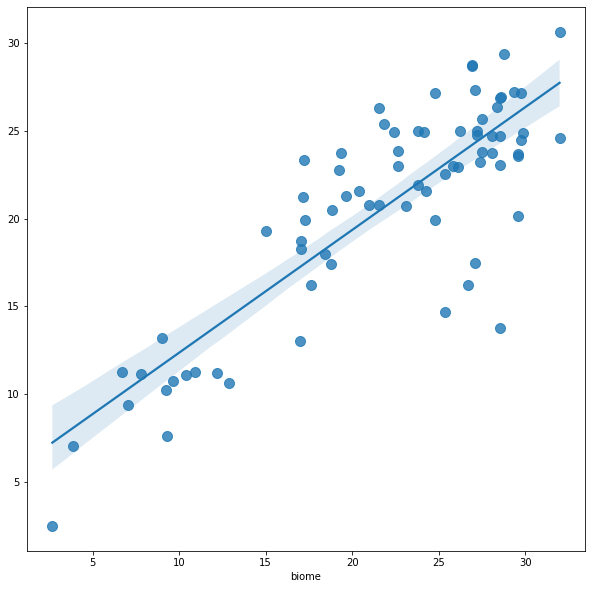

In [122]:
from sklearn import metrics
#X_val, y_val
expected_y  = 2**y_val
predicted_y = 2**model.predict(X_val)
#Here we have printed r2 score and mean squared log error for the Regressor.

print(metrics.r2_score(expected_y, predicted_y))
print(metrics.mean_squared_log_error(expected_y, predicted_y))
    
plt.figure(figsize=(10,10))
sns.regplot(expected_y, predicted_y, fit_reg=True, scatter_kws={"s": 100})

# Feature importance
### temperature focused results

In [123]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_)

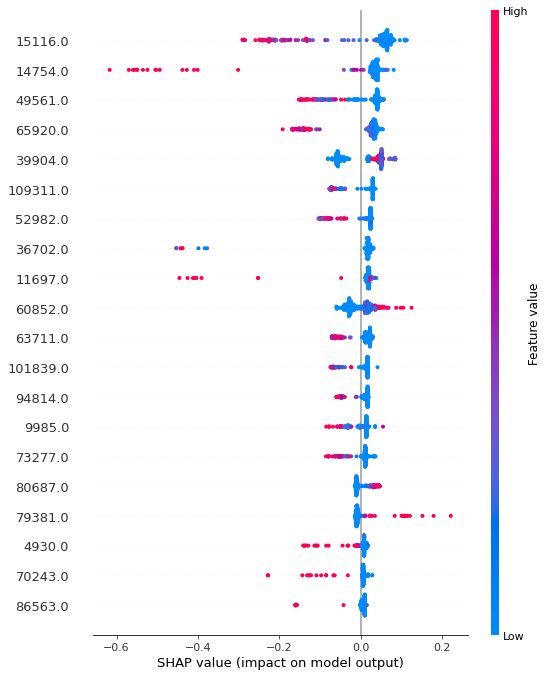

In [129]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_)

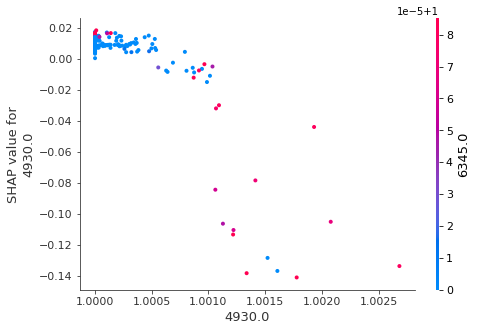

In [139]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("4930.0", shap_values, 2**X_)

# Salinity 

### noticed that predicted plot for salinity indicates not a good model because all points clustered together

In [85]:
h = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")
h['GOLD Analysis Project ID'] = h.GOLD
h = h.fillna(0)
h = h[h.biome_specific.str.contains("Environmental")]
h = h[h.Salinity != 0]
h = h[['GOLD Analysis Project ID', 'Salinity']]
g_copy = h.merge(g, on='GOLD Analysis Project ID', how='left')
g_copy = g_copy[g_copy['112326.0']>-100]

In [86]:
y_ = g_copy.Salinity
X_ = g_copy.drop(['biome','GOLD Analysis Project ID', 'Salinity'], axis=1)
print('length: ',len(X_))

#Best Params :  {'l2_leaf_reg': 25, 'iterations': 5000, 'learning_rate': 0.01, 'bootstrap_type': 'No'}

model = CatBoostRegressor(learning_rate=0.01, bootstrap_type = 'No', 
                          depth = 8, l2_leaf_reg=25,
                         #  border_count=5,
                          iterations=5000,verbose = 500,random_seed=42,
                          loss_function='RMSE',
                          task_type="GPU",)
X_train, y_train, X_train_pool, X_val, y_val, X_val_pool, X_test, y_test = split_the_data_set(X_, y_, random_state=42)
fit_data(leng=2000)

length:  333


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 27.9252984	test: 30.1599734	best: 30.1599734 (0)	total: 10.6ms	remaining: 53.2s
500:	learn: 11.1566788	test: 16.1314990	best: 16.1314990 (500)	total: 3.97s	remaining: 35.6s
1000:	learn: 7.7750352	test: 14.4069463	best: 14.4069463 (1000)	total: 7.89s	remaining: 31.5s
1500:	learn: 6.3609782	test: 14.0062522	best: 14.0062522 (1500)	total: 11.8s	remaining: 27.4s
2000:	learn: 5.5946625	test: 13.5546618	best: 13.5546618 (2000)	total: 15.6s	remaining: 23.4s
2500:	learn: 4.9742286	test: 13.1758524	best: 13.1758524 (2500)	total: 19.5s	remaining: 19.5s
3000:	learn: 4.3323609	test: 12.8738593	best: 12.8738593 (3000)	total: 23.3s	remaining: 15.5s
3500:	learn: 3.8657094	test: 12.7471634	best: 12.7471634 (3500)	total: 27.1s	remaining: 11.6s
4000:	learn: 3.5411413	test: 12.7013034	best: 12.7013034 (4000)	total: 30.9s	remaining: 7.72s
4500:	learn: 3.3342412	test: 12.6478168	best: 12.6472132 (4482)	total: 34.7s	remaining: 3.85s
4999:	learn: 3.1840692	test: 12.7067082	best: 12.6471786 (4516)	t

0.8366761933907584
0.029306896227893037


/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='biome'>

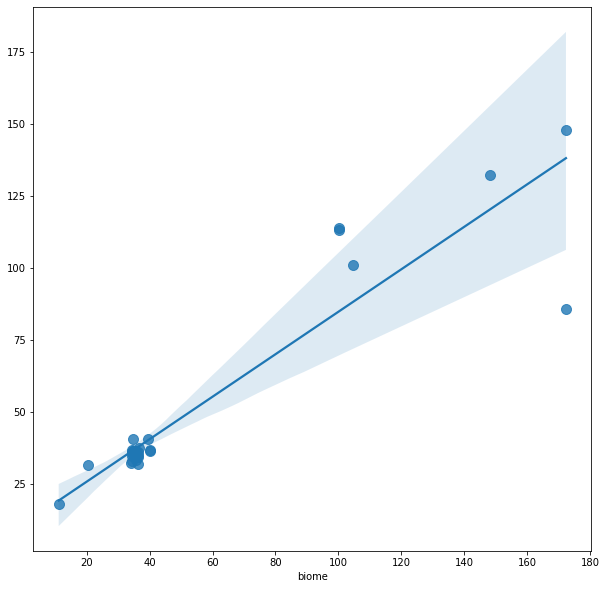

In [87]:
expected_y  = y_test
predicted_y = model.predict(X_test)
#Here we have printed r2 score and mean squared log error for the Regressor.

print(metrics.r2_score(expected_y, predicted_y))
print(metrics.mean_squared_log_error(expected_y, predicted_y))
    
plt.figure(figsize=(10,10))
sns.regplot(expected_y, predicted_y, fit_reg=True, scatter_kws={"s": 100})

# pH

In [97]:
h = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")
h['GOLD Analysis Project ID'] = h.GOLD
h = h.fillna(0)
h = h[h.biome_specific.str.contains("Environmental:Aquatic")]
h = h[h.pH != 0]
h = h[['GOLD Analysis Project ID', 'pH']]
g_copy = h.merge(g, on='GOLD Analysis Project ID', how='left')
g_copy = g_copy[g_copy['112326.0']>-100]

In [ ]:
y_ = np.log2(g_copy.pH)
X_ = g_copy.drop(['biome','GOLD Analysis Project ID', 'pH'], axis=1)
print('length: ',len(X_))

# Best Params :  {'l2_leaf_reg': 25, 'iterations': 5000, 'learning_rate': 0.1, 'bootstrap_type': 'Bayesian'}

model = CatBoostRegressor(learning_rate=0.1, bootstrap_type = 'Bayesian', 
                          depth = 8, l2_leaf_reg=25,
                         #  border_count=5,
                          iterations=5000, verbose = 2500,
                          random_seed=42,
                          loss_function='RMSE',task_type="GPU",)
                        #  custom_metric='Accuracy',
            
#grid = {'iterations':[5000],'learning_rate': [0.1, 0.01, 0.001],'l2_leaf_reg': [1, 25],'bootstrap_type':['Bayesian', 'Bernoulli', 'No'],}
#grid_search_result = model.grid_search(grid, X_, y_, plot=False)
#print("\nBest Params : ", grid_search_result['params'])

X_train, y_train, X_train_pool, X_val, y_val, X_val_pool, X_test, y_test = split_the_data_set(X_, y_, random_state=42)
fit_data(leng=2000)

0.8122623473600804
0.0019133172686622195


/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='biome'>

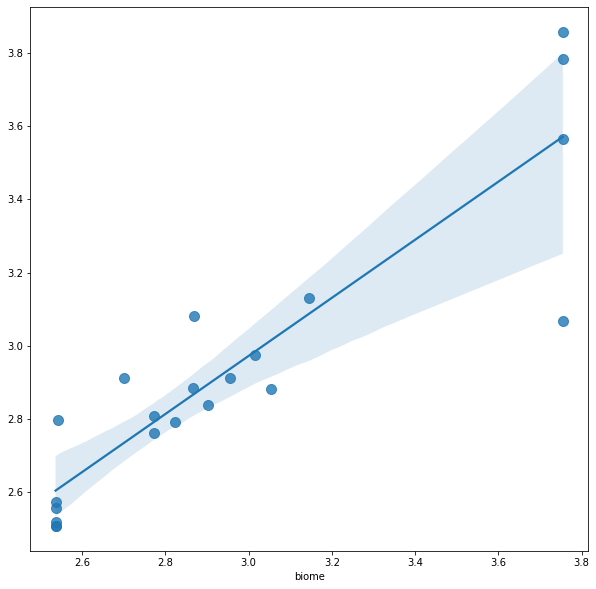

In [101]:
expected_y  = y_test
predicted_y = model.predict(X_test)
#Here we have printed r2 score and mean squared log error for the Regressor.

print(metrics.r2_score(expected_y, predicted_y))
print(metrics.mean_squared_log_error(expected_y, predicted_y))
    
plt.figure(figsize=(10,10))
sns.regplot(expected_y, predicted_y, fit_reg=True, scatter_kws={"s": 100})

# Chlorophyll

In [113]:
h = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")
h['GOLD Analysis Project ID'] = h.GOLD
h = h.fillna(0)
h = h[h.biome_specific.str.contains("Environmental:Aq")]
h = h[h.Chlorophyll_c != 0]
h = h[['GOLD Analysis Project ID', 'Chlorophyll_c']]
g_copy = h.merge(g, on='GOLD Analysis Project ID', how='left')
g_copy = g_copy[g_copy['112326.0']>-100]

In [114]:
y_ = g_copy.Chlorophyll_c
X_ = g_copy.drop(['biome','GOLD Analysis Project ID', 'Chlorophyll_c'], axis=1)
print('length: ',len(X_))

# Best Params :  {'l2_leaf_reg': 1, 'iterations': 5000, 'learning_rate': 0.1, 'bootstrap_type': 'Bayesian'}

model = CatBoostRegressor(learning_rate=0.1, bootstrap_type = 'Bayesian', 
                          depth = 8, l2_leaf_reg=1,
                          iterations=5000,
                           verbose = 1000,random_seed=22,
                          loss_function='RMSE',task_type="GPU",)

X_train, y_train, X_train_pool, X_val, y_val, X_val_pool, X_test, y_test = split_the_data_set(X_, y_, random_state=42)
fit_data(leng=2000)

length:  211


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1989122	test: 0.2910878	best: 0.2910878 (0)	total: 10.1ms	remaining: 50.4s
1000:	learn: 0.0429455	test: 0.1835773	best: 0.1835509 (996)	total: 7.55s	remaining: 30.2s
2000:	learn: 0.0361669	test: 0.1803435	best: 0.1803110 (1910)	total: 15.1s	remaining: 22.6s
3000:	learn: 0.0325138	test: 0.1791635	best: 0.1791073 (2921)	total: 22.6s	remaining: 15s
4000:	learn: 0.0299677	test: 0.1780887	best: 0.1780300 (3964)	total: 30.1s	remaining: 7.51s
4999:	learn: 0.0284737	test: 0.1779589	best: 0.1775806 (4553)	total: 37.6s	remaining: 0us
bestTest = 0.1775805708
bestIteration = 4553
Shrink model to first 4554 iterations.
Test data score: 0.3113568121772833
Validate data score: 0.608236001128855
Train data score: 0.9791368780694494


In [9]:
import plotly.express as px
import geopandas as gpd

In [ ]:
%pip install geopandas

In [36]:
h = pd.read_csv("/global/cfs/cdirs/kbase/KE-Catboost/HK/IMG_dataset_Sean_Filtered.csv")
h = h[h.biome_specific.str.contains("Environmental:Aquatic:M")]
h = h.fillna(0)
h = h[h.T_C != 0]

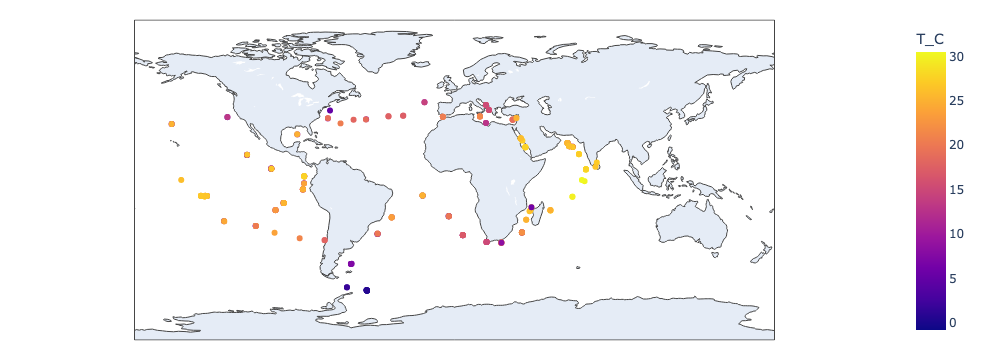

In [47]:
#px.set_mapbox_access_token(open(".mapbox_token").read())
fig = px.scatter_geo(h,
                    lat=h.Latitude,
                    lon=h.Longitude,
                    hover_name=h.T_C,
                     color=h.T_C,
                    )
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
)
fig.show()